In [1]:
import pandas as pd
from collections import Counter
import ast

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics 

import xgboost as xgb

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("nndb.csv")

In [4]:
df["IS_DECEASED"] = df["DEATH_DATE"].notnull()

In [5]:
df.head()

,ID,LINK,WIKI_PAGE,WIKI_ID,NAME,AKA,BIRTH_DATE,BIRTHPLACE,GENDER,RACE,...,DEATH_DATE,LOCATION_OF_DEATH,CAUSE_OF_DEATH,AGE,RISK_FACTORS,WIKI_CAUSE_OF_DEATH,WIKI_DEATH_SUMMARY,WIKI_HEALTH_ISSUES,WIKI_CATEGORIZED_CAUSE,IS_DECEASED
0,fe332275caf5b3ecb55c1a5cd82a959a,http://www.nndb.com/people/076/000131680/,William_Zabka,Q966693,William Zabka,NaN,1965-10-20,NaN,Male,White,...,NaN,NaN,NaN,59,NaN,NaN,NaN,NaN,NaN,False
1,b4f340696e06077b736e737f53cfc498,http://www.nndb.com/people/163/000174638/,Saul_Zaentz,Q736466,Saul Zaentz,NaN,1921-02-28,NaN,Male,White,...,2014-01-03,,NaN,93,NaN,alzheimer disease complications,"Saul Zaentz, a film producer, passed away on J...",NaN,alzheimer,True
2,44a89b724d3f4b683cf6dda035bf6903,http://www.nndb.com/people/551/000128167/,Mike_S._Zafirovski,Q6848679,Mike S. Zafirovski,NaN,1953-11-14,NaN,Male,White,...,NaN,NaN,NaN,71,NaN,NaN,NaN,NaN,NaN,False
3,dff88441adc1313ce3de0f872172b679,http://www.nndb.com/people/251/000354186/,Mariel_Zagunis,Q235756,Mariel Zagunis,Mariel Leigh Zagunis,1985-03-03,NaN,Female,White,...,NaN,NaN,NaN,39,NaN,NaN,NaN,NaN,NaN,False
4,33af84f6a7d28e7b60c6c0908033b459,http://www.nndb.com/people/665/000044533/,Mahmoud_Zahar,Q708854,Mahmoud Zahar,Mahmoud al-Zahar,1945-05-06,Gaza,Male,Middle Eastern,...,NaN,NaN,NaN,79,NaN,NaN,NaN,NaN,NaN,False


In [6]:
data = df.RISK_FACTORS.to_list()

In [7]:
# Function to parse and clean individual strings
def parse_and_clean(s):
    # Check for NaN (float) values
    if isinstance(s, float):
        return []
    # Safely evaluate the string as a list
    parsed_list = ast.literal_eval(s)
    # Clean each element in the list
    return [item.strip() for item in parsed_list]

In [8]:
cleaned_data = [parse_and_clean(row) for row in data]

In [9]:
# Normalize the data: strip spaces and convert to lowercase
normalized_data = [[factor.strip().lower() for factor in sublist] for sublist in cleaned_data]

In [10]:
df2 = pd.DataFrame({'RISK_FACTORS': normalized_data})

In [11]:
# Flatten the list and get unique risk factors, normalized
unique_risk_factors = set(factor for sublist in normalized_data for factor in sublist)

In [12]:
# Create DataFrames for each risk factor and store them in a list
encoded_frames = []
for risk_factor in unique_risk_factors:
    # Create a column for each risk factor with 0s
    risk_factor_col = pd.Series([0] * len(df2))
    
    # Update the column with 1 where the risk factor is present
    for i, row in enumerate(df2['RISK_FACTORS']):
        if isinstance(row, list) and risk_factor in [item.lower().strip() for item in row]:
            risk_factor_col.at[i] = 1

    # Add the column to the list of DataFrames
    temp_df = pd.DataFrame({risk_factor: risk_factor_col})
    encoded_frames.append(temp_df)

In [13]:
# Concatenate all the encoded DataFrames
encoded_df = pd.concat(encoded_frames, axis=1)

# Join the encoded DataFrame with the original DataFrame
df = df.join(encoded_df)

In [14]:
df.obesity.value_counts()

obesity
0    25933
1      301
Name: count, dtype: int64

In [15]:
# Drop the original RISK_FACTORS column if necessary
df.drop('RISK_FACTORS', axis=1, inplace=True)

In [16]:
# df['ID'] = df['ID'].astype("category")
df['GENDER'] = df['GENDER'].astype("category")
df['RACE'] = df['RACE'].astype("category")
df['OCCUPATION'] = df['OCCUPATION'].astype("category")
df['NATIONALITY'] = df['NATIONALITY'].astype("category")
df['BIRTHPLACE'] = df['BIRTHPLACE'].astype("category")
df['WIKI_CATEGORIZED_CAUSE'] = df['WIKI_CATEGORIZED_CAUSE'].astype("category")

In [17]:
# Convert the 'date_column' to datetime, coercing out-of-bounds dates to NaT
df['BIRTH_DATE'] = pd.to_datetime(df['BIRTH_DATE'], errors='coerce')
df['DEATH_DATE'] = pd.to_datetime(df['DEATH_DATE'], errors='coerce')

In [32]:
df_y = df['IS_DECEASED']
df_X = df.drop(columns=['ID', 'IS_DECEASED', 'DEATH_DATE', 'LOCATION_OF_DEATH', 'CAUSE_OF_DEATH', 'NAME', 'AKA', 'LINK', 'BIRTH_DATE', 'EXECUTIVE_SUMMARY', 'WIKI_CAUSE_OF_DEATH', 'WIKI_DEATH_SUMMARY', 'WIKI_HEALTH_ISSUES', 'WIKI_PAGE', 'WIKI_ID'])

In [33]:
id_column = df['ID']
name_column = df['NAME']
age_column = df['AGE']
is_dead_column = df['IS_DECEASED']

In [34]:
# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

In [35]:
# count examples in each class
counter = Counter(df_y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.476


In [37]:
def create_pipe(clf):

    pipeline = Pipeline([('clf', clf)])

    return pipeline

In [38]:
clf = xgb.XGBClassifier(random_state=42, 
                        verbosity=0, 
                        tree_method="hist",
                        enable_categorical=True)

pipeline = create_pipe(clf)

In [39]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [40]:
feat_list = []
xgb_cols = pipeline['clf'].get_booster().feature_names
feat_imp = pipeline['clf'].feature_importances_

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(xgb_cols, feat_imp):
    feat_list.append(feature)
    total_importance += feature[1]
        
# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['SUMMED_TOTAL'] = df_imp['IMPORTANCE'].cumsum()
df_imp.head(15)

,FEATURE,IMPORTANCE,SUMMED_TOTAL
6,WIKI_CATEGORIZED_CAUSE,0.628387,0.628387
5,AGE,0.022341,0.650728
3,OCCUPATION,0.018304,0.669032
79,performance-enhancing drugs,0.016431,0.685463
36,former smoker,0.014137,0.699600
83,vegetarian,0.014128,0.713728
1,GENDER,0.013789,0.727516
66,polio,0.011768,0.739284
137,breast cancer,0.011619,0.750903
112,parkinson's,0.011290,0.762193


In [41]:
def print_confusion(pipeline):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    y_pred = pipeline.predict(X_test)

    print(metrics.classification_report(y_test, y_pred, digits=3))
        
    ConfusionMatrixDisplay.from_predictions(y_test, 
                                            y_pred, 
                                            cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('02_confusion_matrix.png', dpi=300);

              precision    recall  f1-score   support

       False      0.906     0.967     0.935      4687
        True      0.946     0.852     0.897      3184

    accuracy                          0.921      7871
   macro avg      0.926     0.910     0.916      7871
weighted avg      0.922     0.921     0.920      7871



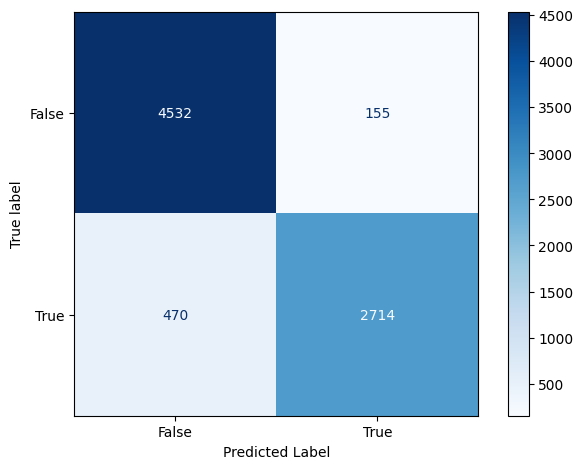

In [42]:
print_confusion(pipeline)

In [43]:
feat_list = []
xgb_cols = pipeline['clf'].get_booster().feature_names
feat_imp = pipeline['clf'].feature_importances_

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(xgb_cols, feat_imp):
    feat_list.append(feature)
    total_importance += feature[1]
        
# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['SUMMED_TOTAL'] = df_imp['IMPORTANCE'].cumsum()
df_imp.head(30)

,FEATURE,IMPORTANCE,SUMMED_TOTAL
6,WIKI_CATEGORIZED_CAUSE,0.628387,0.628387
5,AGE,0.022341,0.650728
3,OCCUPATION,0.018304,0.669032
79,performance-enhancing drugs,0.016431,0.685463
36,former smoker,0.014137,0.699600
83,vegetarian,0.014128,0.713728
1,GENDER,0.013789,0.727516
66,polio,0.011768,0.739284
137,breast cancer,0.011619,0.750903
112,parkinson's,0.011290,0.762193


In [44]:

# Predict the outcome variable based on the model
probs = pipeline.predict_proba(df_X)

# Get the Win probability for the `win` class
probs = probs[:,1]
probs = probs.round(3)

# Combine predictions with the name column
result_df = pd.DataFrame({
    'ID': id_column,
    'NAME': name_column,
    'AGE': age_column,
    'IS_DECEASED': is_dead_column,
    'PREDICTION': probs,
})

# Add the probability percentage to the DataFrame
# X['last_prediction_date'] = pd.Timestamp.today().strftime('%Y-%m-%d')
# X['convert_probability'] = probs.tolist()

In [45]:
result_df = result_df.sort_values('PREDICTION', ascending=False)
result_df

,ID,NAME,AGE,IS_DECEASED,PREDICTION
14697,967cb02d0c8d600bfee6132d56de1fb1,Johnny Ace,25,True,1.0
907,57144de2678e17eee6b9001ac7b49015,Darrent Williams,25,True,1.0
6788,4c0052bfb9ffefd4593f4241851acf7a,Bud Spencer,87,True,1.0
13156,fe49b3cc507d8f4bba3f122532087aa6,Qusay Hussein,36,True,1.0
10290,61c9cd2062a6bf8039c8cc7407348e98,Naguib Mahfouz,95,True,1.0
...,...,...,...,...,...
21246,3ee0f47097b0ea0d180a7a778fac32f4,Cher,78,False,0.0
21257,0ca00eb0bb9a9df45a3ba63ee52b8000,Munro Chambers,34,False,0.0
24365,6a98d0673c776e9ed195fbe5274f7d88,Rebecca Loos,47,False,0.0
23297,e7f9790aa7f0e769afd33d735e6ea6a4,Kareena Kapoor,44,False,0.0


In [46]:
filtered_df = result_df[result_df['IS_DECEASED'] == False]
filtered_df

,ID,NAME,AGE,IS_DECEASED,PREDICTION
7769,4571a54cc66a5d14b779bc00a45f3dd5,Chuck Strahl,67,False,0.998
18492,85600562e865630901d576e832844c7d,George Benson,81,False,0.997
7973,8484a720218bfff79e2a98c0711341e7,Jay Rockefeller,87,False,0.996
25837,02b8834978c91ecfddbdefab025da23e,Brian Littrell,49,False,0.996
11511,5fa092051b86468b74f6b9f2ba57bf6c,Patrick J. Martin,57,False,0.996
...,...,...,...,...,...
21246,3ee0f47097b0ea0d180a7a778fac32f4,Cher,78,False,0.000
21257,0ca00eb0bb9a9df45a3ba63ee52b8000,Munro Chambers,34,False,0.000
24365,6a98d0673c776e9ed195fbe5274f7d88,Rebecca Loos,47,False,0.000
23297,e7f9790aa7f0e769afd33d735e6ea6a4,Kareena Kapoor,44,False,0.000


In [47]:
df_leads = filtered_df[filtered_df['PREDICTION'] >= 0.75]
df_leads

,ID,NAME,AGE,IS_DECEASED,PREDICTION
7769,4571a54cc66a5d14b779bc00a45f3dd5,Chuck Strahl,67,False,0.998
18492,85600562e865630901d576e832844c7d,George Benson,81,False,0.997
7973,8484a720218bfff79e2a98c0711341e7,Jay Rockefeller,87,False,0.996
25837,02b8834978c91ecfddbdefab025da23e,Brian Littrell,49,False,0.996
11511,5fa092051b86468b74f6b9f2ba57bf6c,Patrick J. Martin,57,False,0.996
...,...,...,...,...,...
4307,fed5d13410abb6c1f7bb32e6eeff6b1c,Leo Sayer,76,False,0.758
4843,141eceb2aa3dedd14263463533ca67b3,LeAnn Rimes,42,False,0.755
11534,57030fb81e44dc0fc7a4525557ba4a75,Grace Napolitano,88,False,0.755
23257,91a7ed3acf64c24920353d8f825ef217,Tim Kaine,66,False,0.754


In [48]:
df_leads.to_csv('dead_pool_leads.csv', index=False)
